# Check the effect of miRNA levels on PTEN protein abundance 

 "miR-25 and miR-93 (from MCM7) expression decrease PTEN protein levels, and result in activation of the Akt pathway." https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3095470/
 Could this help explain the tissue dependant effects?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u
import plot_utils as p

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [4]:
'''
Params
all_prot: list of trans genes
utils: from cptac

Returns a dataframe with trans proteomics and mutation status (PTEN deletion or wt)
'''

def all_prot_format_df(cancer_object, all_prot = ['PTEN'], gene_in = 'PTEN', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad', 'endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot,
            tissue_type = 'tumor') # drop Normal samples
        
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1) 

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('luad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name = 'proteomics', genes1 = gene_in, 
            genes2 = all_prot, tissue_type = 'tumor') # Get only tumor samples
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns = 'PTEN_CNV')
        
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
        
    elif cancer_object.get_cancer_type() in ('endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot,
            tissue_type = 'tumor') # drop Normal samples
        
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1) 

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep two values to compare
        compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
                        mut_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

    return mut_wt


In [5]:
def status(row, q1, q3):
    #print(row,'\tq1:',q1,'\tq3:',q3)
    status = 'na'
    for val in row: 
        if pd.isnull(val):
            continue
        val = float(val)
        if val <= q1:
            status = 'low'
        elif val >= q3:
            status = 'high'
        else:
            status = 'med'
        return status

#  Step 1: Load datasets

Load in cancer data sets from cptac. 

In [6]:
g = cptac.Gbm()
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
col = cptac.Colon()
b = cptac.Brca()

# Step 2: Prepare df for plotting

Each cancer needs a data frame containing tumor samples that have PTEN cnv deletions or PTEN wildtype, PTEN proteomics, and miRNA data.  

In [7]:
cancer_objects = {'GBM':g, 'HNSCC':h, 'LSCC':ls, 'EC': en, 'CO':col} # miRNA not in Brca and Ov # Luad different labels

miRNA_list = ['hsa-miR-25-3p', 'hsa-miR-25-5p', 'hsa-miR-93-3p', 'hsa-miR-93-5p']

prepared_dfs = {}

for mirna in miRNA_list:
    mut_pval_df = pd.DataFrame()
    wt_pval_df = pd.DataFrame()
    
    for cancer in cancer_objects:
        df = cancer_objects[cancer].get_miRNA(tissue_type = 'tumor')
        if isinstance(df.keys(), pd.core.indexes.multi.MultiIndex):
            df = u.reduce_multiindex(df, levels_to_drop = 1)
        # check if miRNA is in dataframe
        if df[df.columns[df.columns.isin([mirna])]].empty == False: 
            mirna_df = df[[mirna]]
        else:
            continue

        # Get pten proteomics for tumors with mutation
        wt_del = all_prot_format_df(cancer_objects[cancer], all_prot = ['PTEN'], gene_in = 'PTEN')
        pten = wt_del[['PTEN_proteomics','Mutation']]

        # keep miRNA_status and PTEN_proteomics
        both = pten.join(mirna_df[[mirna]], how = 'outer')
        
        # Put df into dfs dictionary for reference later
        prepared_dfs[cancer+'_'+mirna[8:]] = both
    

# Step 3: Linear Regression

Use the plot_pearson function to plot PTEN proteomics and miRNA abundance and calculate the Pearson correlation. At least 30 values are needed to use this function. 

In [8]:
# choose miRNA for analysis
miRNA_list = ['hsa-miR-25-3p', 'hsa-miR-25-5p', 'hsa-miR-93-3p', 'hsa-miR-93-5p']
mirna = miRNA_list[0]
print(mirna)

hsa-miR-25-3p


# GBM

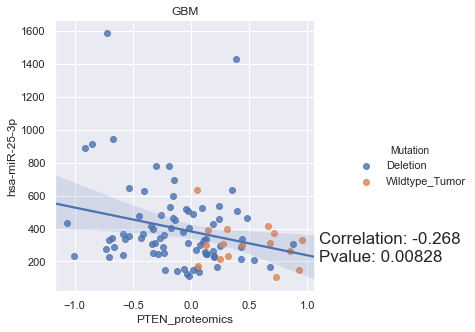

In [24]:
cancer = 'GBM'
plot_df = prepared_dfs[cancer+'_'+mirna[8:]]

p.plot_pearson(plot_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
               hue = "Mutation", title = cancer, ra_stats = True, x_coor = 1.1, y_coor = 200,
               show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:])

In [25]:
print(cancer, 'wt')
wt_df = plot_df.loc[plot_df['Mutation'] == 'Wildtype_Tumor']

if len(wt_df) > 30:
    p.plot_pearson(wt_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, x_coor = 1.1, y_coor = 200,
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_wt')
else:
    print('not enough data')

GBM wt
not enough data


GBM PTEN deletion


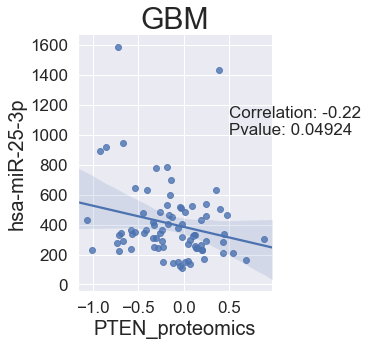

In [30]:
print(cancer, 'PTEN deletion')
mut_df = plot_df.loc[plot_df['Mutation'] != 'Wildtype_Tumor']

if len(mut_df) > 30:
    p.plot_pearson(mut_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, x_coor = .5, y_coor = 1000,
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_mut')
else:
    print('not enough data')

# HNSCC

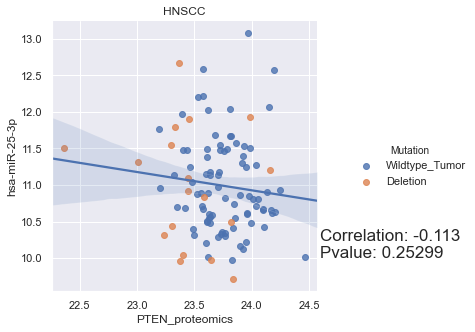

In [12]:
cancer = 'HNSCC'
plot_df = prepared_dfs[cancer+'_'+mirna[8:]]

p.plot_pearson(plot_df,x_axis = "PTEN_proteomics", y_axis = mirna, 
               hue = "Mutation", title = cancer, ra_stats = True, x_coor = 24.6, y_coor = 10.0,
               show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:])

HNSCC wt


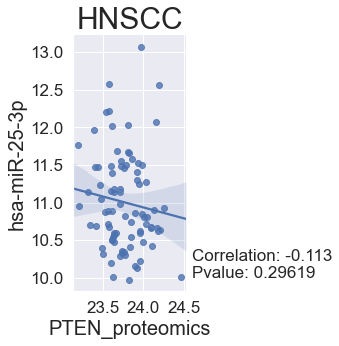

In [13]:
print(cancer, 'wt')
wt_df = plot_df.loc[plot_df['Mutation'] == 'Wildtype_Tumor']

if len(wt_df) > 30:
    p.plot_pearson(wt_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, x_coor = 24.6, y_coor = 10.0,
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_wt')
else:
    print('not enough data')

In [14]:
print(cancer, 'PTEN deletion')
mut_df = plot_df.loc[plot_df['Mutation'] != 'Wildtype_Tumor']

if len(mut_df) > 30:
    p.plot_pearson(mut_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, 
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_mut')
else:
    print('not enough data')

HNSCC PTEN deletion
not enough data


# LSCC

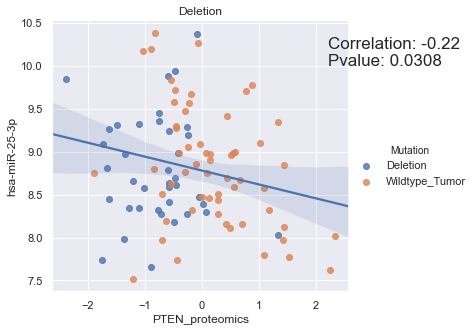

In [15]:
cancer = 'LSCC'
plot_df = prepared_dfs[cancer+'_'+mirna[8:]]

p.plot_pearson(plot_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
               hue = 'Mutation', title = 'Deletion', ra_stats = True, x_coor = 2.2, y_coor = 10.0,
               show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:])

LSCC wt


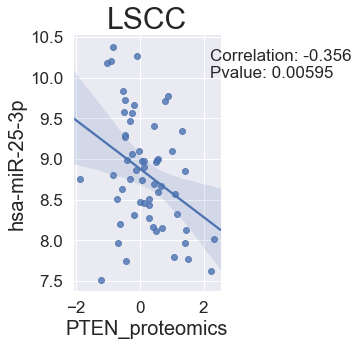

In [16]:
print(cancer, 'wt')
wt_df = plot_df.loc[plot_df['Mutation'] == 'Wildtype_Tumor']

if len(wt_df) > 30:
    p.plot_pearson(wt_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, x_coor = 2.2, y_coor = 10.0,
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_wt')
else:
    print('not enough data')

LSCC PTEN deletion


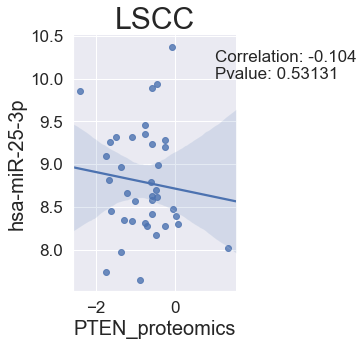

In [17]:
print(cancer, 'PTEN deletion')
mut_df = plot_df.loc[plot_df['Mutation'] != 'Wildtype_Tumor']

if len(mut_df) > 30:
    p.plot_pearson(mut_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, x_coor = 1.0, y_coor = 10.0,
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_mut')
else:
    print('not enough data')

# EC

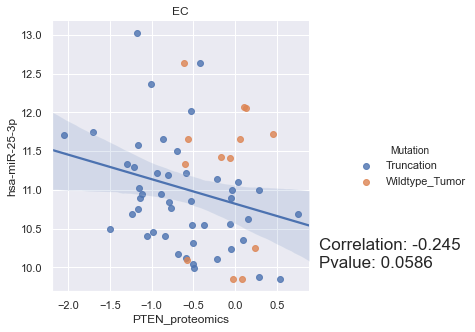

In [18]:
cancer = 'EC'
plot_df = prepared_dfs[cancer+'_'+mirna[8:]]
plot_t = plot_df.loc[plot_df['Mutation'] == 'Truncation']
plot_wt = plot_df.loc[plot_df['Mutation'] == 'Wildtype_Tumor']

p.plot_pearson(plot_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
               hue = "Mutation", title = cancer, ra_stats = True, x_coor = 1.0, y_coor = 10.0,
               show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:])

In [19]:
print(cancer, 'wt')
wt_df = plot_df.loc[plot_df['Mutation'] == 'Wildtype_Tumor']

if len(wt_df) > 30:
    p.plot_pearson(wt_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, x_coor = 24.6, y_coor = 10.0,
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_wt')
else:
    print('not enough data')

EC wt
not enough data


EC PTEN deletion


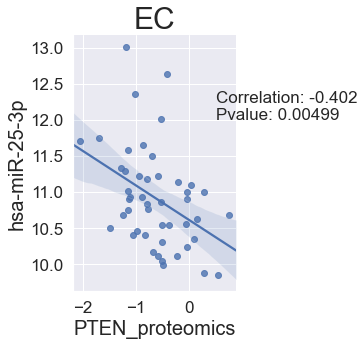

In [20]:
print(cancer, 'PTEN deletion')
mut_df = plot_df.loc[plot_df['Mutation'] != 'Wildtype_Tumor']

if len(mut_df) > 30:
    p.plot_pearson(mut_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, x_coor = .5, y_coor = 12.0,
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_mut')
else:
    print('not enough data')

# CO

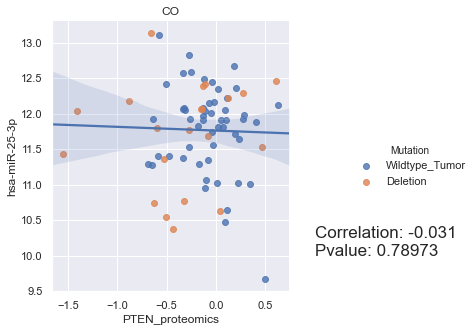

In [21]:
cancer = 'CO'
plot_df = prepared_dfs[cancer+'_'+mirna[8:]]

p.plot_pearson(plot_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
               hue = "Mutation", title = cancer, ra_stats = True, x_coor = 1.0, y_coor = 10.0,
               show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:])

CO wt


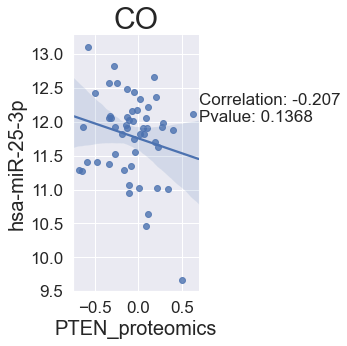

In [22]:
print(cancer, 'wt')
wt_df = plot_df.loc[plot_df['Mutation'] == 'Wildtype_Tumor']

if len(wt_df) > 30:
    p.plot_pearson(wt_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, x_coor = .7, y_coor = 12.0,
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_wt')
else:
    print('not enough data')

In [23]:
print(cancer, 'PTEN deletion')
mut_df = plot_df.loc[plot_df['Mutation'] != 'Wildtype_Tumor']

if len(mut_df) > 30:
    p.plot_pearson(mut_df, x_axis = "PTEN_proteomics", y_axis = mirna, 
                   title = cancer, ra_stats = True, 
                   show_plot = True, save_file_name = 'png_files/'+cancer+'_'+mirna[8:]+'_mut')
else:
    print('not enough data')

CO PTEN deletion
not enough data
